# This project examines patterns in manufacturing defects

Data is provided by Bosch

## Import and examine the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

tic = time.process_time()

training set has 1023747 records

test set has 1183747 records

In [2]:
folder = 'Bosch-Production-Line-Performance/'
batch_size = 20000
chunksize = 20000
train_num_records = 1023748
skiprows = np.random.randint(1, train_num_records+1, size=train_num_records-batch_size)

# Let's make this dataset somewhat balanced:

### First, let's get the FAIL rows:

Because there's so few, I'll have to scour the entire dataset and get all of them for there to be enough of them

In [3]:
%%time

train_numeric_fail = pd.read_csv(folder+'train_numeric.csv', nrows=1) #initialize
train_categorical_fail = pd.read_csv(folder+'train_categorical.csv', nrows=1) #initialize
train_date_fail = pd.read_csv(folder+'train_date.csv', nrows=1) #initialize


for chunk in pd.read_csv(folder+'train_numeric.csv', chunksize=chunksize):
    chunk.drop(chunk[chunk['Response']==0].index, inplace=True)
    train_numeric_fail = train_numeric_fail.append(chunk)

train_numeric_fail.drop(train_numeric_fail[train_numeric_fail['Response']==0].index, inplace=True) #remove dummy row from initialize
print(train_numeric_fail.shape)


for chunk in pd.read_csv(folder+'train_categorical.csv', chunksize=chunksize, low_memory=False):
    train_categorical_fail = train_categorical_fail.append(chunk[chunk['Id'].isin(train_numeric_fail['Id'])])


train_categorical_fail = train_categorical_fail[train_categorical_fail['Id'].isin(train_numeric_fail['Id'])] #remove dummy row from initialize
print(train_categorical_fail.shape)
   

for chunk in pd.read_csv(folder+'train_date.csv', chunksize=chunksize, low_memory=False):
    train_date_fail = train_date_fail.append(chunk[chunk['Id'].isin(train_numeric_fail['Id'])])
    
train_date_fail = train_date_fail[train_date_fail['Id'].isin(train_numeric_fail['Id'])] #remove dummy row from initialize
print(train_date_fail.shape)

(6879, 970)
(6879, 2141)
(6879, 1157)
CPU times: user 13min 14s, sys: 44.3 s, total: 13min 58s
Wall time: 14min 1s


### Second, let's get the PASS rows:

This is much easier, I'll just grab some random rows and remove the fails

In [4]:
%%time

train_categorical_pass = pd.read_csv(folder+'train_categorical.csv', nrows=batch_size, skiprows=skiprows, low_memory=False)
train_numeric_pass = pd.read_csv(folder+'train_numeric.csv', nrows=batch_size, skiprows=skiprows)
train_date_pass = pd.read_csv(folder+'train_date.csv', nrows=batch_size, skiprows=skiprows)


train_numeric_pass.drop(train_numeric_pass[train_numeric_pass['Response']==1].index, inplace=True)
train_categorical_pass = train_categorical_pass[train_categorical_pass['Id'].isin(train_numeric_pass['Id'])]
train_date_pass = train_date_pass[train_date_pass['Id'].isin(train_numeric_pass['Id'])]


print(train_numeric_pass.shape)
print(train_categorical_pass.shape)
print(train_date_pass.shape)

(19890, 970)
(19890, 2141)
(19890, 1157)
CPU times: user 10.7 s, sys: 843 ms, total: 11.5 s
Wall time: 11.6 s


### Third, let's merge the PASS and FAIL into a simple SAMPLE dataframe

Recall that we did Pass and Fail separately because Fails were so hard to find

In [5]:
train_categorical_sample = pd.concat([train_categorical_pass, train_categorical_fail])
train_numeric_sample = pd.concat([train_numeric_pass, train_numeric_fail])
train_date_sample = pd.concat([train_date_pass, train_date_fail])

print(train_categorical_sample.shape)
print(train_numeric_sample.shape)
print(train_date_sample.shape)

(26769, 2141)
(26769, 970)
(26769, 1157)


### Fourth, let's create the FEATURE dataframe by merging NUMERIC and CATEGORICAL

Could be useful to simplify

In [6]:
# merge categorical and numeric together for total train_features_sample DataFrame
train_feature_sample = pd.merge(train_categorical_sample, train_numeric_sample,on='Id')

print(train_feature_sample.shape)

(26769, 3110)


### And finally, let's delete the PASS and FAIL dataframes, since they're no more use to us

Only useful for balancing the dataset, which we now have with the SAMPLE dataframes

In [7]:
del train_categorical_fail, train_numeric_fail, train_date_fail, train_categorical_pass, train_numeric_pass, train_date_pass

del chunk

## Let's now start to get combinations of stations

Because this will be massive if we just get every single combination, let's just get the adjacent combinations (connected by "connections")

In [8]:
def extractLSF(string, isDate=False):
    '''
    Given a string in the Bosch Line/Station/Feature format (eg: L0_S0_F26), extract the Line number, Station number, and Feature number
    
    Input: String in Lx_Sy_Fz format
    
    Output:  Tuple of (x, y, z)
    
    Sidenote:  isDate will extract based on Lx_Sy_Dd format instead, returns tuple of (x, y, d)
    '''
    # first assert the format is correct:
    splitStr = string.split('_')
    if isDate:
        prefixList = ['L', 'S', 'D']
    else:
        prefixList = ['L', 'S', 'F']
        
    assert len(splitStr) == 3, 'Not 3 substrings split by "_"s!'
    for i in range(0, len(splitStr)):
        assert splitStr[i][1:].isnumeric(), 'Not numeric following the single-letter prefix!'
        assert splitStr[i][:1] == prefixList[i], 'Not the proper single-letter prefixes!  Did you use a Date format and forget to set isDate=True?'
    
    #now extract numbers:
    tempList = []
    
    for substr in splitStr:
        number = float(substr[1:])
        if number%1 == 0.0:
            tempList.append(int(number))
        else:
            tempList.append(number)
        
    return tuple(tempList)

# ----------------------------------------------------------------------------------------------------

def getListLSF(inputSeries, isDate=False):
    '''
    Given a series with fields of Bosch style Lx_Sy_Fz: Get the lines, stations, and features (or dates)
    Input:  series (row) in a Bosch-style QC matrix
    Output:  pandas dataframe of lines, stations, and features/dates
    '''
    
    for field in inputSeries.index:
        try:
            myL, myS, myF = extractLSF(field, isDate=isDate)
        except:
            continue
        listL.append(myL)
        listS.append(myS)
        listF.append(myF)
    
    return {'Lines': listL, 'Stations': listS, 'Features': listF}

# ----------------------------------------------------------------------------------------------------

def getListLSD(inputSeries):
    return getListLSF(inputSeries, isDate=True)


# All L/S/Fs------------------------------------------------------------------------------------------

def get_lsf(lsf_df, isDate=False):
    '''From a Bosch DF, extract all the Line/Station/Feature combinations in the fields
    Outputs a Dataframe of columns Line, Station, Feature'''
    if isDate:
        lsf = pd.DataFrame(columns=['Line', 'Station', 'Date'])
    else:
        lsf = pd.DataFrame(columns=['Line', 'Station', 'Feature'])
    
    for field in lsf_df.columns:
        try:
            lsf = lsf.append(pd.DataFrame([list(extractLSF(field, isDate))], columns=lsf.columns))
        except:
            continue
    
    return lsf

# ----------------------------------------------------

def dataframeSpecificColumns(data, columnname, isDate=False):
    '''Returns a dataframe of Bosch format, but reformat the columns to show ONLY feature, or ONLY station, etc
    Input: data (dataframe), columnname
    Output: dataframe with extracted feature/station/whatever'''
        
    cols = ['Id']
    cols.extend(list(get_lsf(data, isDate)[columnname]))

    if 'Response' in data.columns:
        cols.append('Response')
        
    df = data.copy()
    df.columns = cols
    
    return df

In [9]:
# Returns a list of adjacent combinations
# I'll eventually use wrapper functions so I can modify the combosize and STILL use .apply()

def listToString(listOfInts, separator='/'):
    string = ''
    for number in listOfInts:
        string = string + str(number) + separator
    return string[:-1]


def uniqueList(inputlist):
    output = []
    for x in inputlist:
        if x not in output:
            output.append(x)
    return output


def getConnections(inputSeries, combosize=2, unique=False, stringOutput=False):
    '''
    Get a list of tuples for all connections, starting from -1 (Start), and ending at either 99 (Pass), or 100 (Fail)
    
    Input:  A Series with a lot of NaNs, and indexes are Station Names (integers)
    
    Output: A List of Tuples with all connections of Pairs of Adjacent Stations without NaNs
    '''
    try:
        inputSeries.drop('Response', inplace=True)
    except:
        pass
    droppedNa = list(inputSeries.dropna().drop('Id').index)

    listOfConnections = []
    for i in range(0, len(droppedNa)-(combosize-1)):
        templist = [droppedNa[x] for x in range(i, i+combosize)]
        listOfConnections.append(templist)

    if unique:
        output = uniqueList(listOfConnections)
    else:
        output = listOfConnections
        
    if stringOutput:
        return [listToString(conn) for conn in output]
    else:
        return output

### Now let's create some dataframes...

With Stations as columns, and with Features as columns

In [10]:
train_date_sample_datecols = dataframeSpecificColumns(train_date_sample, 'Date', isDate=True)

#----------------

train_feature_sample_stationcols = dataframeSpecificColumns(train_feature_sample, 'Station')

#-----------------

train_feature_sample_featurecols = dataframeSpecificColumns(train_feature_sample, 'Feature')

# --------------------------------Testing Combos Codes-----------------------------------

In [11]:
def getListFrequency(item, listOfItems):
    count = 0
    for i in listOfItems:
        if i == item:
            count += 1
    return count

def getConnectionFrequency(inputList, allConnections):
    
    frequencies = np.zeros(len(allConnections))

    for i in range(0, len(allConnections)):
        item = allConnections[i]
        frequencies[i] = getListFrequency(item, inputList)#number of allConnections[i] in inputList
    
    return frequencies.reshape(1,len(allConnections))

In [53]:
%%time
# This is when I can enter the Connection Combo Size that I want to test

comboSize = 1
wantUniqueConnections = True
#-------------------------------------

def getConnections_Custom_Uniques(inputSeries):
    return getConnections(inputSeries, combosize=comboSize, unique=wantUniqueConnections, stringOutput=True)

seriesConnections = train_feature_sample_stationcols.apply(getConnections_Custom_Uniques, axis=1)

CPU times: user 1min 10s, sys: 1.53 s, total: 1min 11s
Wall time: 1min 17s


In [54]:
%%time
#TESTING
# Creating a SET of all connections for the columns for my Connections DF... then converting to a list

allConnections = set(())

for product in seriesConnections:
    allConnections.update(product)

allConnections = list(allConnections)

CPU times: user 25.3 ms, sys: 34 µs, total: 25.3 ms
Wall time: 25.5 ms


In [55]:
%%time
connectionFrequency = pd.DataFrame(np.zeros((seriesConnections.size, len(allConnections))), columns=pd.Series(allConnections), index=seriesConnections.index)

for row in seriesConnections.index:
    connectionFrequency.loc[row] = getConnectionFrequency(seriesConnections[row], allConnections)

results = train_feature_sample_stationcols['Response']

print(connectionFrequency.head())

    15   37    6   45   24    8   23   11    2    0 ...     7   34    3   17  \
0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0 ...   1.0  1.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0 ...   1.0  1.0  1.0  0.0   
2  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0 ...   1.0  1.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  1.0  0.0  1.0   
4  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0 ...   1.0  1.0  0.0  0.0   

    33   13   16   25   32   26  
0  1.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  0.0  0.0  
2  1.0  0.0  0.0  0.0  0.0  0.0  
3  1.0  1.0  0.0  0.0  0.0  0.0  
4  1.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 50 columns]
CPU times: user 6.14 s, sys: 23.8 ms, total: 6.17 s
Wall time: 6.2 s


# Dimensionality Reduction #1

### Principle Component Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaledData = scaler.fit_transform(connectionFrequency)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
n_components = 2

pca = PCA(n_components=n_components)
pca.fit(scaledData)

scaledData.shape

In [ ]:
x_pca = pca.transform(scaledData)

x_pca.shape #I just reduced MANY dimensions to just 2!

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=results,cmap='cool', s=15, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Dimensionality Reduction #2

### Independent Component Analysis

In [44]:
from sklearn.decomposition import FastICA

In [45]:
n_components = 2

ica = FastICA(n_components=n_components)
ica.fit(scaledData)

scaledData.shape

(26769, 1963)

In [46]:
x_ica = ica.transform(scaledData)

x_ica.shape

(26769, 2)

Text(0, 0.5, 'Second Independent Component')

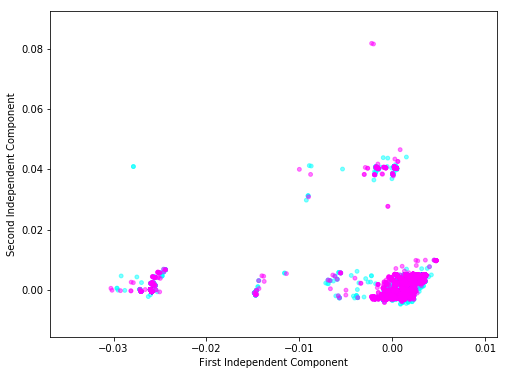

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(x_ica[:,0],x_ica[:,1],c=results,cmap='cool', s=15, alpha=0.5)
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')

# Dimensionality Reduction #3

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [25]:
from sklearn.manifold import TSNE

In [27]:
n_iter = 300

tsne = TSNE(n_components=2, n_iter=n_iter).fit(scaledData)

In [30]:
tsne = TSNE(n_components=2, n_iter=n_iter).fit_transform(scaledData)

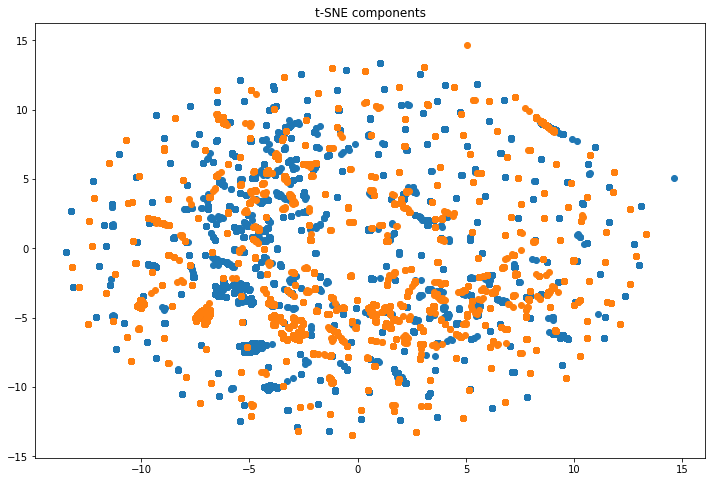

In [34]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,0])

# Dimensionality Reduction #4

### Uniform Manifold Approximation and Projection (UMAP)

# ------------------------------Random Forest --------------------------------------------

In [34]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(x_pca, results, test_size=0.20)

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
tree = RandomForestClassifier(n_estimators=60)
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
importances = tree.feature_importances_

indices = np.argsort(importances[-9:]) #top 10 features

Text(0.5, 0, 'Relative Importance')

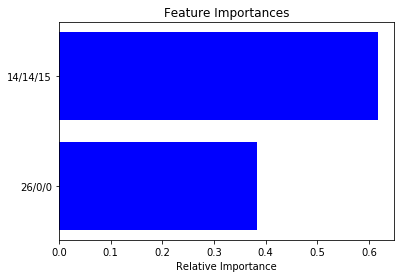

In [51]:
features = connectionFrequency.columns

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [52]:
y_predict_tree = tree.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

In [54]:
print(confusion_matrix(y_test, y_predict_tree))
print(classification_report(y_test, y_predict_tree))

[[3879  125]
 [1114  238]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      4004
           1       0.66      0.18      0.28      1352

   micro avg       0.77      0.77      0.77      5356
   macro avg       0.72      0.57      0.57      5356
weighted avg       0.75      0.77      0.71      5356



# ----------------------------------Support Vector Machines-----------------------------

In [55]:
from sklearn.svm import SVC

In [56]:
svm = SVC()
svm.fit(X_train, y_train)

/home/han/.conda/envs/tf-gpu/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [57]:
y_predict_svm = svm.predict(X_test)

In [58]:
print(confusion_matrix(y_test, y_predict_svm))
print(classification_report(y_test, y_predict_svm))

[[3975   29]
 [1156  196]]
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      4004
           1       0.87      0.14      0.25      1352

   micro avg       0.78      0.78      0.78      5356
   macro avg       0.82      0.57      0.56      5356
weighted avg       0.80      0.78      0.71      5356

